# **Framework for Near-Real Time Sensor-Agnostic Water Classification**

A new image is acquired at T1. Landsat (and potentially Sentinel-2) water masks are aggregated from a period of time T0 (T1-3months). Assuming no significant (TBD) change between T0 and T1 in water extent, it should be possible to identify likely change pixels at the boundary of class distributions if sampled across a representative a large enough area (TBD). Omitting such potential change features enables a significant no. training samples at T1 and these may be used to provide water (+ probability) masks at T1 for all clearsky pixels at T1.

Assumptions
- At least 'somewhat' a complete water mask can be obtained by generating a water summary product for T0
- There is a sufficient area of 'clearsky' within the T1 image
- Class transitions are on a sufficiently limited scale that either
    - (1) they do not need to be omitted and model selection will be robust enough to treat them as outliers, or
    - (2) they can be identified as outliers from the major class distributions using skewness/kurtosis
- 

## **Summary**
- (1) create T1-1m water mask & prep T1 image
    - load available T1-1m water masks (naturally L8 for now)
    - load T1 dataset (L8 for now too)
    - apply T1 dataset clearsky mask
- (2) check class distributions of T1 image w/ T1-1m water mask
- (3) train classifier on T1 image w/ T1-1m water mask
- (4) run classifier on full T1 image
- (5) export results & underlying image + masks

In [38]:
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
# Set reference for util modules
import sys
sys.path.append('/home/jovyan/odc-hub/')
# Generic python
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr 
from datetime import datetime

# sac-specific
from sac_utils.createAOI import create_lat_lon

# dc-specific
from datacube import Datacube
from datacube.storage.masking import mask_invalid_data
dc = Datacube()

# ml stuff
from sklearn.ensemble import RandomForestClassifier

# dask stuff
import dask.array
import dask
from dask.distributed import Client
client = Client('dask-scheduler.dask.svc.cluster.local:8786')
client

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Client Scheduler: tcp://dask-scheduler.dask.svc.cluster.local:8786 Dashboard: http://dask-scheduler.dask.svc.cluster.local:8787/status,Cluster Workers: 5 Cores: 40 Memory: 168.65 GB


# **(0) Set consistent params**

In [152]:
T0 = ('2017-12-10', '2018-2-10')
T1 = ('2018-2-10', '2018-2-12')

T1_prod = "ls8_usgs_sr_scene"
T1_measurements = ["green","red","blue","nir","swir1","swir2", "pixel_qa"]
T1_vars = ['green','red','blue','nir','swir1','swir2']

In [153]:
# arbitrary small-ish aoi (over suva)
aoi_wkt = "POLYGON((178.36592371675124 -18.061324867751413,178.60178644868483 -18.061324867751413,178.60178644868483 -18.20357994407414,178.36592371675124 -18.20357994407414,178.36592371675124 -18.061324867751413)))"
# resulution
res = 30

output_crs = "EPSG:32760"
latitude, longitude = create_lat_lon(aoi_wkt)
# latitude = (-18.2962, -17.2867)
# longitude = (177.1594, 178.7222)
resolution = (-res, res)

In [154]:
# consistent channel for viewing plots + determining dims
ref_channel = 'red'

# **(1) create T0 water mask (T1-3months)**

**load T0 water masks**

In [155]:
product = 'ls8_water_classification'
measurements = ['water']

water_dataset = dc.load(
    product=product,
    time=T0, # quarter prior to T1 
    lat=latitude,
    lon=longitude,
    output_crs=output_crs,
    resolution=resolution,
    measurements = measurements,
    group_by='solar_day',
    dask_chunks={
        #'time': 1,
        'x': 1000,
        'y': 1000,
    }
)
water_dataset

<xarray.Dataset>
Dimensions:  (time: 11, x: 837, y: 532)
Coordinates:
  * time     (time) datetime64[ns] 2017-12-16T22:12:59 ... 2018-02-04T22:00:18
  * y        (y) float64 8.002e+06 8.002e+06 8.002e+06 ... 7.987e+06 7.987e+06
  * x        (x) float64 6.444e+05 6.445e+05 6.445e+05 ... 6.695e+05 6.695e+05
Data variables:
    water    (time, y, x) int16 dask.array<shape=(11, 532, 837), chunksize=(1, 532, 837)>
Attributes:
    crs:      EPSG:32760

fully **remove nodata** pixels (can't just use ==-9999 due to potential nn averaging within dc.load() at res <native

In [156]:
# Identify pixels with valid data
good_quality = (
    (water_dataset.water >= 0) # no data
)
# Apply mask
water_dataset = water_dataset.where(good_quality)

**define dask computation** of water summary product

In [157]:
mean_dataset = water_dataset.water.mean(dim='time')

**apply computation** to water masks dataset & plot

In [158]:
%%time
mean_dataset = mean_dataset.compute()

CPU times: user 92.3 ms, sys: 39.9 ms, total: 132 ms
Wall time: 7.18 s


In [159]:
del water_dataset
client.restart()

Client Scheduler: tcp://dask-scheduler.dask.svc.cluster.local:8786 Dashboard: http://dask-scheduler.dask.svc.cluster.local:8787/status,Cluster Workers: 5 Cores: 40 Memory: 168.65 GB


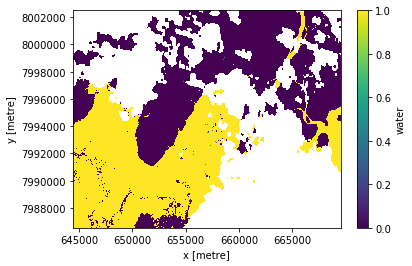

In [160]:
fig, ax = plt.subplots()
# ax.imshow(mean_dataset)
mean_dataset.plot(ax=ax)

**create binary water mask** based on summary product (based off likelihood of being persistent water bodies)

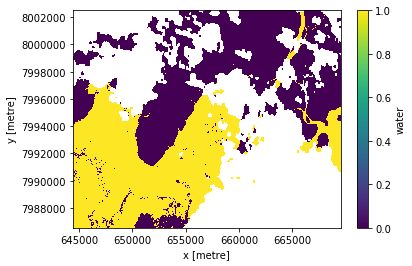

In [161]:
waterpres_prob = 0.75
T0_nd_water = np.isnan(mean_dataset)
T0_water = mean_dataset.where((mean_dataset < waterpres_prob) | (T0_nd_water == True), 1) # fix > prob to water
T0_water = T0_water.where((T0_water >= waterpres_prob) | (T0_nd_water == True), 0) # fix < prob to no water 

fig, ax = plt.subplots()
T0_water.plot(ax=ax)

# **(2) load T1 image**

**load** l8

In [162]:
product = T1_prod
measurements = T1_measurements

landsat_dataset = dc.load(
    product=product,
    time=T1, # we know a nice single image is here
    lat=latitude,
    lon=longitude,
    output_crs=output_crs,
    resolution=resolution,
    measurements = measurements,
    group_by='solar_day',
    dask_chunks={
        #'time': 1,
        'x': 1000,
        'y': 1000,
    }
)
landsat_dataset

<xarray.Dataset>
Dimensions:   (time: 1, x: 837, y: 532)
Coordinates:
  * time      (time) datetime64[ns] 2018-02-11T22:06:27
  * y         (y) float64 8.002e+06 8.002e+06 8.002e+06 ... 7.987e+06 7.987e+06
  * x         (x) float64 6.444e+05 6.445e+05 6.445e+05 ... 6.695e+05 6.695e+05
Data variables:
    green     (time, y, x) int16 dask.array<shape=(1, 532, 837), chunksize=(1, 532, 837)>
    red       (time, y, x) int16 dask.array<shape=(1, 532, 837), chunksize=(1, 532, 837)>
    blue      (time, y, x) int16 dask.array<shape=(1, 532, 837), chunksize=(1, 532, 837)>
    nir       (time, y, x) int16 dask.array<shape=(1, 532, 837), chunksize=(1, 532, 837)>
    swir1     (time, y, x) int16 dask.array<shape=(1, 532, 837), chunksize=(1, 532, 837)>
    swir2     (time, y, x) int16 dask.array<shape=(1, 532, 837), chunksize=(1, 532, 837)>
    pixel_qa  (time, y, x) uint16 dask.array<shape=(1, 532, 837), chunksize=(1, 532, 837)>
Attributes:
    crs:      EPSG:32760

apply **clearsky mask** to image

In [163]:
# Identify pixels with valid data
good_quality = (
    (landsat_dataset.pixel_qa == 322)  | # clear
    (landsat_dataset.pixel_qa == 386)  |
    (landsat_dataset.pixel_qa == 834)  |
    (landsat_dataset.pixel_qa == 898)  |
    (landsat_dataset.pixel_qa == 1346) |
    (landsat_dataset.pixel_qa == 324)  | # water
    (landsat_dataset.pixel_qa == 388)  |
    (landsat_dataset.pixel_qa == 836)  |
    (landsat_dataset.pixel_qa == 900)  |
    (landsat_dataset.pixel_qa == 1348)
)
# Apply mask
landsat_dataset = landsat_dataset.where(good_quality)

**isolate image**

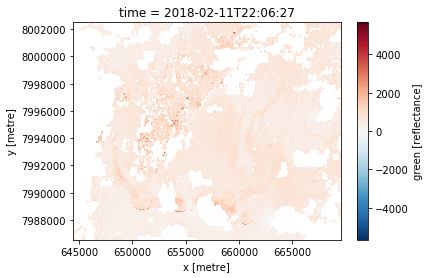

In [164]:
T1_img = landsat_dataset.isel(time = 0)
T1_img[ref_channel].plot()

# **(#) Load T1 Water Mask** for validation

**load T1 water mask** for validation

In [165]:
product = 'ls8_water_classification'
measurements = ['water']

water_dataset = dc.load(
    product=product,
    time=T1, 
    lat=latitude,
    lon=longitude,
    output_crs=output_crs,
    resolution=resolution,
    measurements = measurements,
    group_by='solar_day',
    dask_chunks={
        #'time': 1,
        'x': 1000,
        'y': 1000,
    }
)
water_dataset

<xarray.Dataset>
Dimensions:  (time: 1, x: 837, y: 532)
Coordinates:
  * time     (time) datetime64[ns] 2018-02-11T22:06:27
  * y        (y) float64 8.002e+06 8.002e+06 8.002e+06 ... 7.987e+06 7.987e+06
  * x        (x) float64 6.444e+05 6.445e+05 6.445e+05 ... 6.695e+05 6.695e+05
Data variables:
    water    (time, y, x) int16 dask.array<shape=(1, 532, 837), chunksize=(1, 532, 837)>
Attributes:
    crs:      EPSG:32760

fully remove nodata pixels (can't just use ==-9999 due to potential nn averaging within dc.load() at res <native

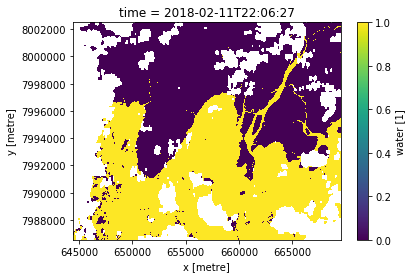

In [166]:
# Identify pixels with valid data
good_quality = (
    (water_dataset.water >= 0) # no data
)
# Apply mask
water_dataset = water_dataset.where(good_quality)

T1_water = water_dataset.isel(time = 0).water
T1_water.plot()

# **(3) Data fusion prep**

Training (class exploration + training):
- create outside merge nodata mask
- apply outside merge nodata mask
- numpify xr dataset(arrays)
- flatten
- remove nodata (can't be sparse for training)
- transpose

Inference
- [create outside merge, if validating]
- [apply no data mask]
- numpify
- flatten
- [1] remove nodata for accurate validation
- [2] replace nodata to maintain positioning

## (3A) Training prep

**create outside merge of nodata** - T1 img + T0 water mask

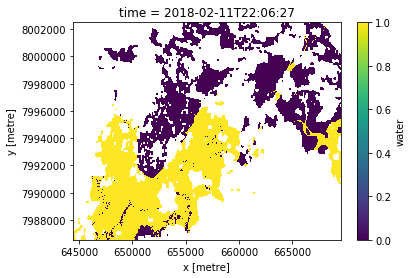

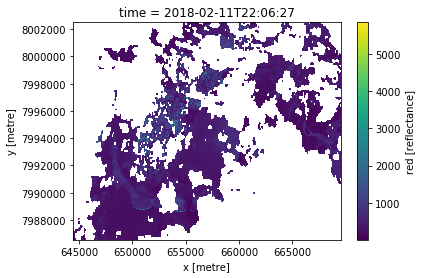

In [167]:
# create mask
T0_nd_img = np.isnan(T1_img)[ref_channel]
T0_nd = T0_nd_water.where((T0_nd_img == False),True)

# apply mask
Ytrain = T0_water.where((T0_nd == False))
Xtrain = T1_img.where((T0_nd == False))

fig, ax = plt.subplots()
Ytrain.plot(ax=ax)
fig, ax = plt.subplots()
Xtrain.where(Xtrain[ref_channel]>0)[ref_channel].plot(ax=ax)

**numpify** T1 image data

In [168]:
des_vars = T1_vars

lenx, leny = np.shape(Xtrain[ref_channel]) # dims of each raster
dsvals = np.zeros([len(des_vars),lenx, leny]) #set up array based on shape of xr and no. des bands

for i, m in zip(np.arange(0,len(Xtrain.data_vars),1), Xtrain.variables): # loop through bands in xr
    print(i, m)
    if m in des_vars: # only want relevant channels
        vals = np.array(Xtrain[m].values) # extract only the reflectance values
        dsvals[i,:,:] = vals # append to 'master' ND array
# plt.imshow(dsvals[0,:,:])

0 green
1 red
2 blue
3 nir
4 swir1
5 swir2
6 pixel_qa


**re-shape**/flatten T1 data + T0 labels

In [169]:
Xtrain = dsvals.reshape(dsvals.shape[0], lenx * leny)  # reshape into nbands x 1D arrays
Ytrain = Ytrain.values.flatten()

Xtrain.shape, Ytrain.shape

((6, 445284), (445284,))

**remove coincident nd from arrays** variables

In [170]:
Xtrain = np.array([i[~np.isnan(i)] for i in Xtrain])
Ytrain = Ytrain[~np.isnan(Ytrain)]

Xtrain.shape, Ytrain.shape

((6, 141034), (141034,))

**transpose** variables

In [171]:
Xtrain = Xtrain.transpose()  # transpose so that bands are read as features

Xtrain.shape, Ytrain.shape

((141034, 6), (141034,))

## (3B) Inference Validation Prep

**create outside merge of nodata** - T1 img + T1 water mask

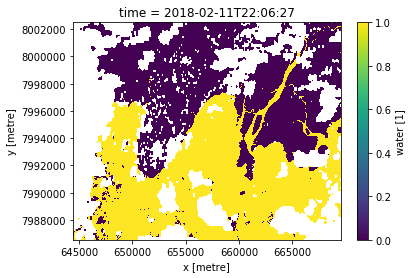

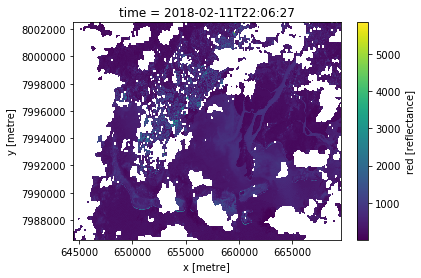

In [172]:
# create
T1_nd_water = np.isnan(T1_water)
T1_img_nd = np.isnan(T1_img)[ref_channel]
T1_merge_nd = T1_nd_water.where((T1_img_nd == False),True)
# apply
Yval = T1_water.where((T1_merge_nd == False))
Xval = T1_img.where((T1_merge_nd == False))

fig, ax = plt.subplots()
Yval.plot(ax=ax)
fig, ax = plt.subplots()
Xval.where(Xval[ref_channel]>0)[ref_channel].plot(ax=ax)

**numpify** T1 image data - within merge

In [173]:
des_vars = T1_vars

lenx, leny = np.shape(Xval[ref_channel]) # dims of each raster
dsvals = np.zeros([len(des_vars),lenx, leny]) #set up array based on shape of xr and no. des bands

for i, m in zip(np.arange(0,len(Xval.data_vars),1), Xval.variables): # loop through bands in xr
    print(i, m)
    if m in des_vars: # only want relevant channels
        vals = np.array(Xval[m].values) # extract only the reflectance values
        dsvals[i,:,:] = vals # append to 'master' ND array
# plt.imshow(dsvals[0,:,:])

0 green
1 red
2 blue
3 nir
4 swir1
5 swir2
6 pixel_qa


**re-shape**/flatten T1 data + T1 labels

In [174]:
Xval = dsvals.reshape(dsvals.shape[0], lenx * leny)  # reshape into nbands x 1D arrays
Yval = Yval.values.flatten()

Xval.shape, Yval.shape

((6, 445284), (445284,))

**remove coincident nd from arrays** variables

In [175]:
Xval = np.array([i[~np.isnan(i)] for i in Xval])
Yval = Yval[~np.isnan(Yval)]

Xval.shape, Yval.shape

((6, 273208), (273208,))

**transpose** variables

In [176]:
Xval = Xval.transpose()  # transpose so that bands are read as features

Xval.shape, Yval.shape

((273208, 6), (273208,))

## (3C) Inference Implementation Prep

**numpify** T1 image data - within merge

In [177]:
des_vars = ['green','red','blue','nir','swir1','swir2']

lenx, leny = np.shape(T1_img[ref_channel]) # dims of each raster
dsvals = np.zeros([len(des_vars),lenx, leny]) #set up array based on shape of xr and no. des bands

for i, m in zip(np.arange(0,len(T1_img.data_vars),1), T1_img.variables): # loop through bands in xr
    print(i, m)
    if m in des_vars: # only want relevant channels
        vals = np.array(T1_img[m].values) # extract only the reflectance values
        dsvals[i,:,:] = vals # append to 'master' ND array
# plt.imshow(dsvals[0,:,:])

0 green
1 red
2 blue
3 nir
4 swir1
5 swir2
6 pixel_qa


**re-shape**/flatten T1 data + T1 labels

In [178]:
Ximp = dsvals.reshape(dsvals.shape[0], lenx * leny)  # reshape into nbands x 1D arrays

Ximp.shape

(6, 445284)

**replace coincident nd from arrays** variables

**transpose** variables

In [179]:
Ximp = Ximp.transpose()  # transpose so that bands are read as features

Ximp.shape

(445284, 6)

In [180]:
foundnans = np.isnan(Ximp)
Ximp[foundnans] = 0

# **(4) Class Exploration**

**separate class vars**

In [256]:
X, Y = Xtrain, Ytrain
X, X.shape, Y,Y.shape

x_t = [X[:, i][Y==1] for i in range(X.shape[1])]
x_f = [X[:, i][Y==0] for i in range(X.shape[1])]
# x_t, x_f

**plot native class distributions in available vars**

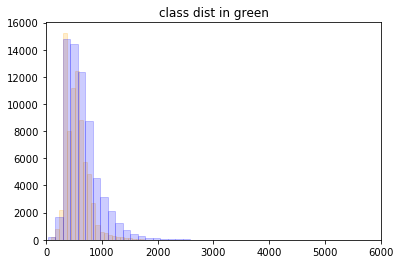

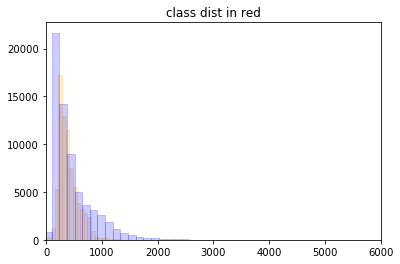

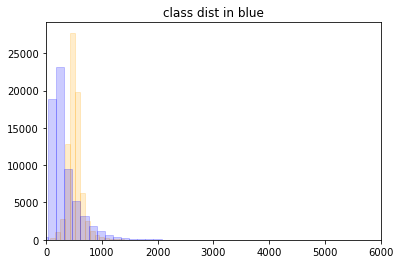

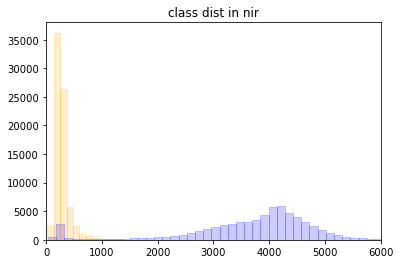

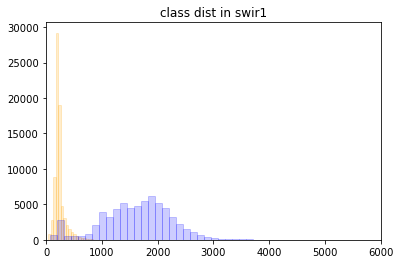

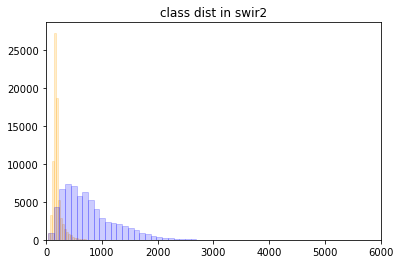

In [265]:
n_bins = 50
i = 0
for t, f in zip(x_t, x_f):
    fig, ax = plt.subplots()
    ax.set_title(f"class dist in {[j for j in T1_img][i]}")
    ax.hist(t, bins=n_bins, color='orange', edgecolor='orange',alpha=0.2);
    ax.hist(f, bins=n_bins, color='blue', edgecolor='blue',alpha=0.2)
    ax.set_xlim(0, 6000)
    i+=1

In [266]:
from sklearn.decomposition import PCA

In [267]:
pca = PCA(n_components=2)

In [268]:
pca.fit(x_t)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [270]:
print(pca.singular_values_)
print(pca.explained_variance_ratio_)

[108252.37409081  43347.87026035]
[0.80217466 0.12862625]


In [282]:
x_t_tpca = pca.fit_transform(np.transpose(x_t))
x_f_tpca = pca.transform(np.transpose(x_f))

x_f_fpca = pca.fit_transform(np.transpose(x_f))
x_t_fpca = pca.transform(np.transpose(x_t))

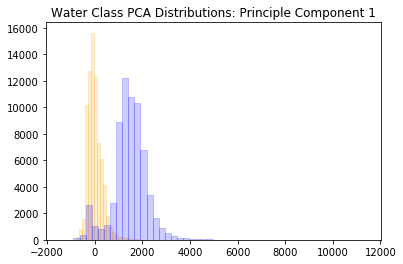

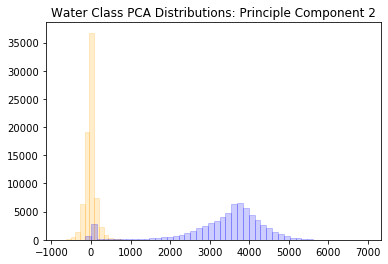

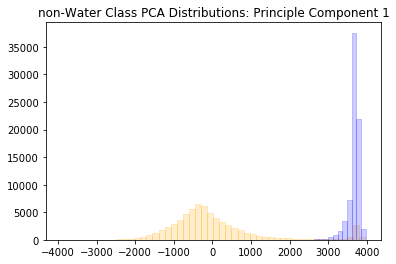

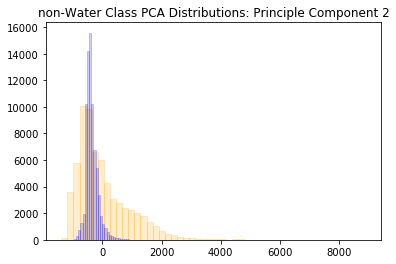

In [301]:
for i, p in enumerate(['Principle Component 1','Principle Component 2']):
    fig, ax = plt.subplots()
    ax.set_title(f'Water Class PCA Distributions: {p}')
    ax.hist(x_t_tpca[:,i], bins=n_bins, color='orange', edgecolor='orange',alpha=0.2);
    ax.hist(x_f_tpca[:,i], bins=n_bins, color='blue', edgecolor='blue',alpha=0.2);

for i, p in enumerate(['Principle Component 1','Principle Component 2']):
    fig, ax = plt.subplots()
    ax.set_title(f'non-Water Class PCA Distributions: {p}')
    ax.hist(x_f_fpca[:,i], bins=n_bins, color='orange', edgecolor='orange',alpha=0.2);
    ax.hist(x_t_fpca[:,i], bins=n_bins, color='blue', edgecolor='blue',alpha=0.2);

TBD

# **(5) Training of T1 using T0 labels**

define **model params**

In [181]:
# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')

**fit model**

In [182]:
rf = model.fit(Xtrain, Ytrain)

**score model on training set** - should be replaced with cross-validation

In [183]:
rf_score = rf.score(Xtrain, Ytrain)
rf_score

0.9999929095111817

extract & plot **variable importances**

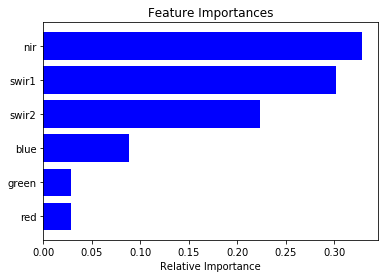

In [184]:
importances = rf.feature_importances_

indices = np.argsort(importances)
features = [i for i in T1_img]
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

extract and **plot decision tree** - TBC

# **(6) Validate against full T1 image & mask**

In [185]:
rf_val_res = rf.predict(Xval)
rf_val_probs = rf.predict_proba(Xval)[:, 1]

In [186]:
rf_val_score = rf.score(Xval, Yval)
f"{round(rf_val_score, 4)*100} %"

'96.81 %'

# **(6) Implement on full T1 image**

In [187]:
predicted = rf.predict(Ximp)
predicted = np.array(predicted)
probability = rf.predict_proba(Ximp)[:, 1]
probability = np.array(probability)

make dataset again

In [188]:
predicted[foundnans[:,0]] = np.nan
probability[foundnans[:,0]] = np.nan

In [189]:
predicted = np.reshape(predicted, [lenx, leny])
probability = np.reshape(probability, [lenx, leny])

Text(0.5, 1.0, 'SWIR1 Channel')

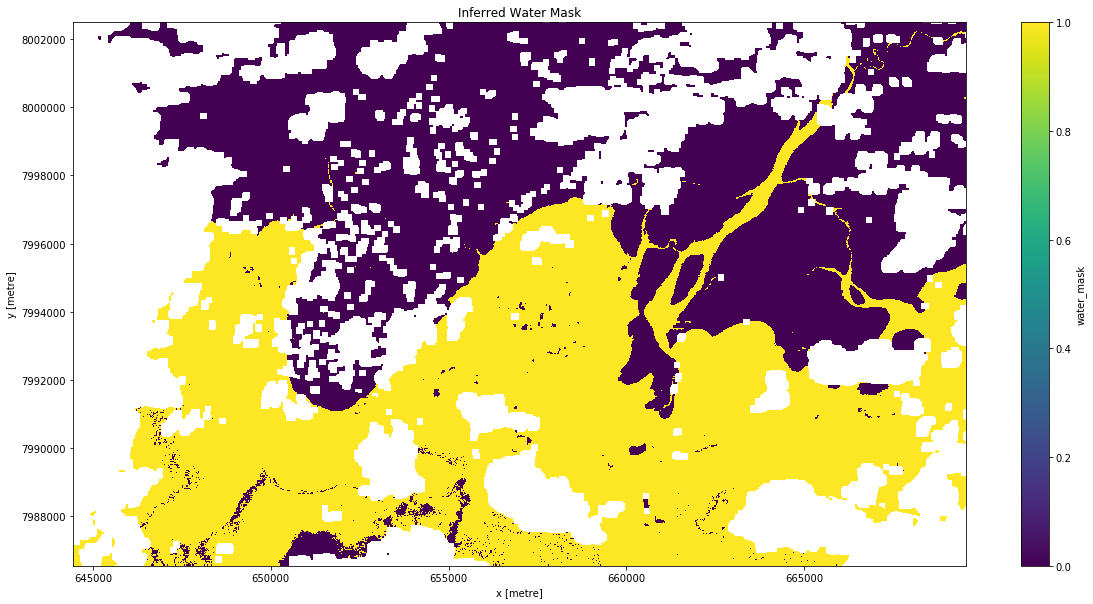

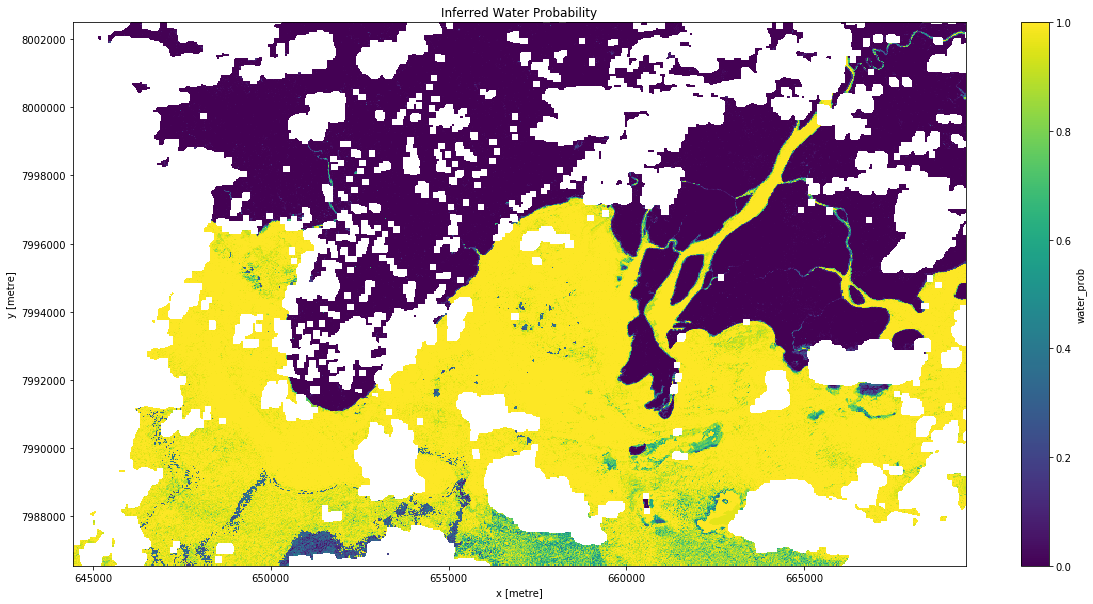

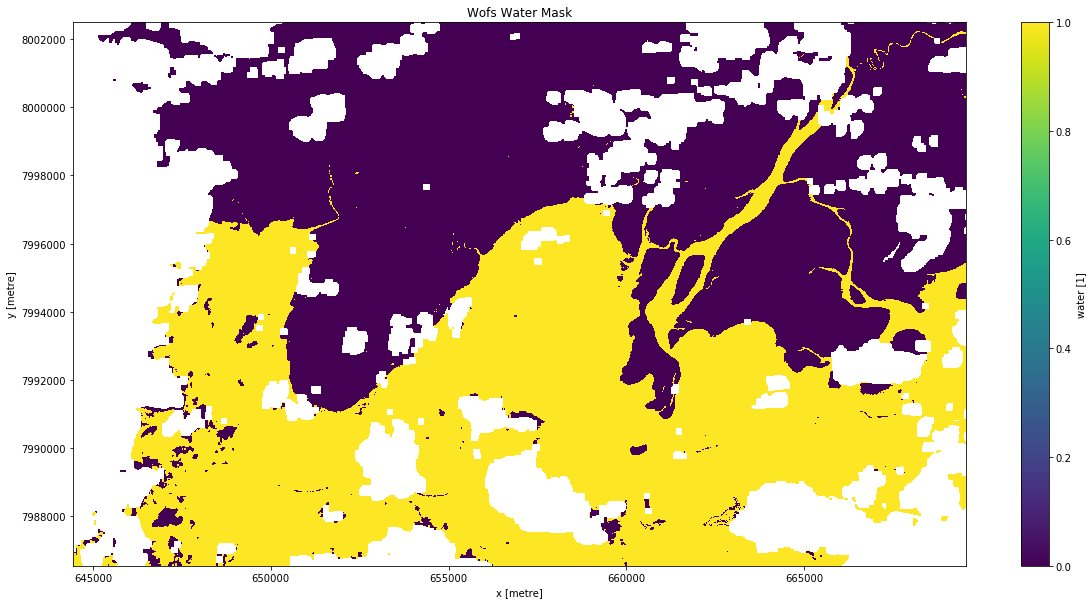

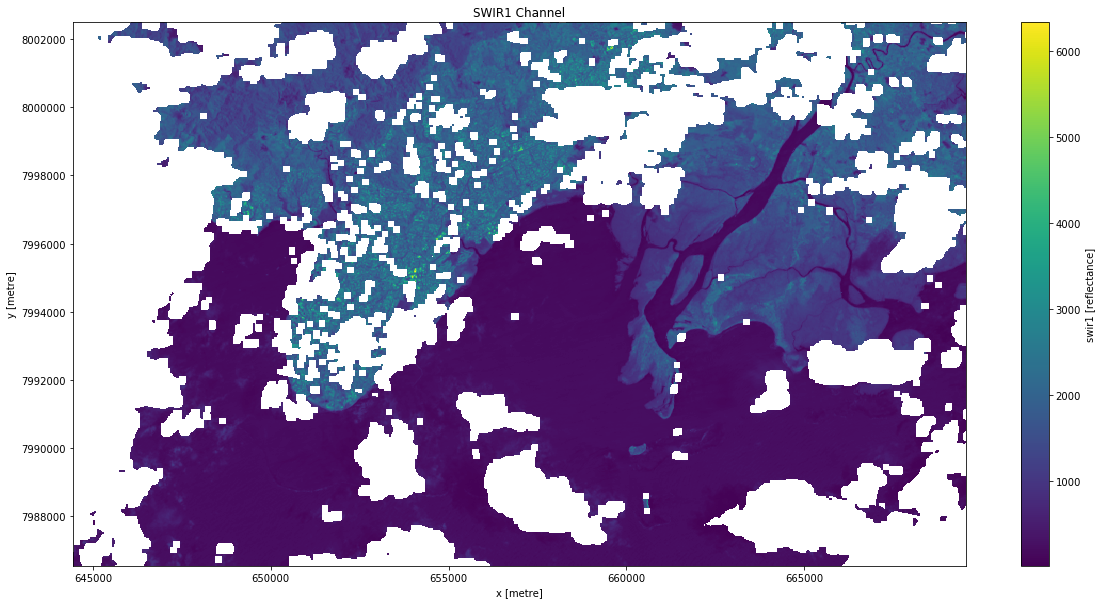

In [190]:
ds = landsat_dataset
ds['water_mask'] = (('y','x'), predicted)
ds['water_prob'] = (('y','x'), probability)

fig, ax = plt.subplots(figsize=(20,10))
ds.water_mask.plot(ax=ax);
ax.set_title('Inferred Water Mask')
fig, ax = plt.subplots(figsize=(20,10))
ds.water_prob.plot(ax=ax);
ax.set_title('Inferred Water Probability')
fig, ax = plt.subplots(figsize=(20,10))
T1_water.plot(ax=ax);
ax.set_title('Wofs Water Mask')
fig, ax = plt.subplots(figsize=(20,10))
ds.swir1.where(ds.red>0).plot(ax=ax);
ax.set_title('SWIR1 Channel');

# **(7) Export(s)**